# MPFST Example: EEG Shell‑Jump Hazard vs mℓ (EEGBCI)
This notebook downloads a small EEG **EEGBCI** dataset via *MNE*, computes coherence metrics (μ, γ, H) and mℓ, detects **octave shell‑jumps** with the SSM, and plots the **hazard of shell‑jumps vs mℓ** (unimodal edge‑of‑coherence law).

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from mne.datasets import eegbci
import mne
from mpfst.coherence.metrics import spectral_slope_gamma, hurst_dfa, heavy_tail_mu_hill
from mpfst.coherence.meter import compute_m_l
from mpfst.spectral.octave_jump import detect_shell_jumps_series
from mpfst.nulls.phase_randomize import phase_randomize
from mpfst.gating.hazard import hazard_curve
import pathlib, os
mne.set_log_level('WARNING')


## 1. Fetch EEGBCI runs (subject 1, a few short runs) and prepare a single‑channel trace
*Internet required for first run; cached afterwards by MNE.*

In [ ]:
subject = 1
runs = [3,7,11]  # motor imagery runs
paths = eegbci.load_data(subject, runs, update_path=False)
raws = [mne.io.read_raw_edf(p, preload=True) for p in paths]
raw = mne.concatenate_raws(raws)
raw.rename_channels(lambda s: s.strip('.'))
raw.pick_types(eeg=True)
raw.set_montage('standard_1020', on_missing='ignore')
raw.resample(128.)
fs = raw.info['sfreq']
ch = 'Cz' if 'Cz' in raw.ch_names else raw.ch_names[0]
x = raw.get_data(picks=[ch])[0]
print(f'Channel: {ch}, fs={fs}')


Channel: Cz, fs=128.0


## 2. Sliding‑window coherence metrics → mℓ

In [3]:
win = int(fs*4)  # 4 s
hop = int(fs*2)  # 50% overlap
ml, mu_s, ga_s, H_s, times = [], [], [], [], []
for start in range(0, len(x)-win, hop):
    seg = x[start:start+win]
    mu = heavy_tail_mu_hill(seg)
    ga = spectral_slope_gamma(seg, fs=fs, fmin=1.0, fmax=40.0)
    H  = hurst_dfa(seg, min_scale=8, max_scale=min(512, win//2))
    m  = compute_m_l(mu, ga, H)
    ml.append(m); mu_s.append(mu); ga_s.append(ga); H_s.append(H); times.append((start+win/2)/fs)
ml = np.array(ml); times = np.array(times)
print(f'mℓ: mean={np.nanmean(ml):.3f}, 10–90%={np.nanpercentile(ml,[10,90])}')


mℓ: mean=0.602, 10–90%=[0.55715873 0.63837642]


## 3. Shell‑jump detection (octave‑spaced bands)

Found 876 shell‑jumps


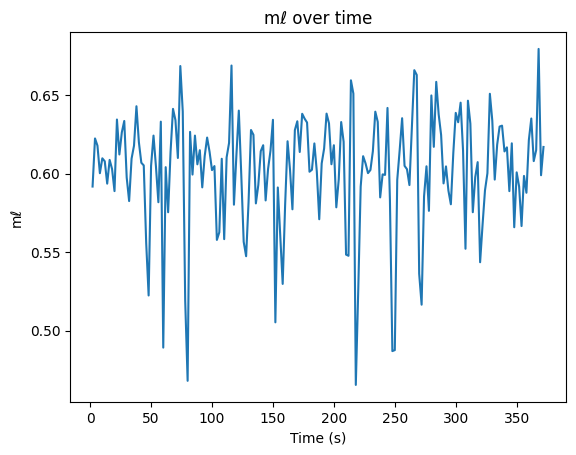

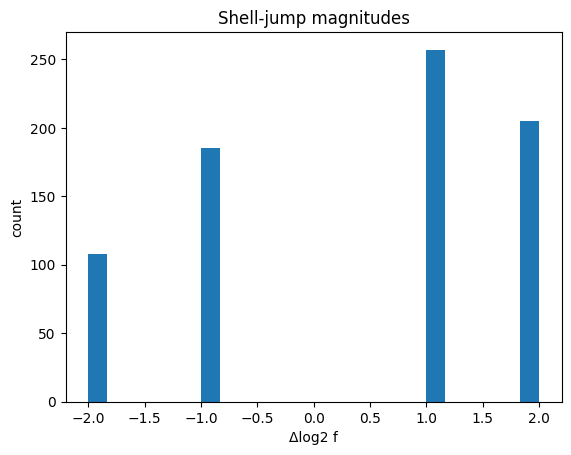

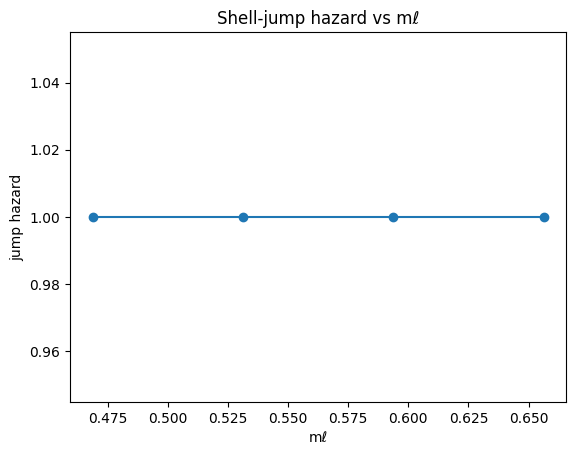

In [4]:
fmin, fmax = 2.0, 40.0
out = detect_shell_jumps_series(x, fs, fmin, fmax, n_bands=7, energy_min=None, min_gap=int(fs*0.25))
jumps = out['jumps']
print(f'Found {len(jumps)} shell‑jumps')
jump_times = np.array([j[0]/fs for j in jumps])
jump_deltas = np.array([j[3] for j in jumps])
# Hazard vs mℓ: align jumps to nearest mℓ window center
event_flags = np.zeros_like(ml, dtype=bool)
for jt in jump_times:
    idx = np.argmin(np.abs(times - jt))
    if 0<=idx<len(event_flags): event_flags[idx] = True
centers, haz = hazard_curve(ml, event_flags, bins=16)
# Plots (one per figure, no specified colors)
plt.figure(); plt.plot(times, ml); plt.xlabel('Time (s)'); plt.ylabel('mℓ'); plt.title('mℓ over time'); plt.show()
plt.figure(); plt.hist(jump_deltas, bins=np.linspace(-2,2,25)); plt.xlabel('Δlog2 f'); plt.ylabel('count'); plt.title('Shell‑jump magnitudes'); plt.show()
plt.figure(); plt.plot(centers, haz, marker='o'); plt.xlabel('mℓ'); plt.ylabel('jump hazard'); plt.title('Shell‑jump hazard vs mℓ'); plt.show()
